# Introduction

Again, the goal of this project is to see if we can use machine learning models to better predict the prices of Magic: The Gathering Cards.

In [part 1]() we looked at web scraping our data, exploring it, and then transforming it into a usable dataset.  In this section, we'll first use a rolling mean of the previous 7 days and then use that as a baseline.  We'll then apply some long short-term memory models to see if we can beat that baseline and better predict the prices going forward.  

In [1]:
import numpy as np
from math import sqrt
import pandas as pd

# Plotting
import matplotlib.pyplot as plt
from bokeh.io import output_notebook, show
from bokeh.plotting import figure, output_file, show
from bokeh.models import Legend
output_notebook()

import warnings

# Sklearn libraries 
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error

# LSTM Libraries 
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM

# Custom Package Written to Scape Webdata
from Web_Scrape import scrape_data

Loading BokehJS ...

Using TensorFlow backend.


Beyond these libraries, let's also load in some functions we previously wrote to help us transform our data.

In [2]:
def shift_timeseries(data: pd.DataFrame, lag: int=1): 
    """
        Takes in a single column and shifts the data down by the
        number from 'lag.' Places zero in new spot.
        
        Input:
            data: Dataframe of a single column
            lag: Number of steps to shift data
        Returns:
            Dataframe with orignal data and shifted data
    """
    df = pd.DataFrame(data)
    
    columns = [df.shift(i) for i in range(1, lag+1)]
    columns.append(df)
    df = pd.concat(columns, axis=1)
    df.columns = ["Predict Price", "Price"]
    df.fillna(0, inplace=True)
    return df

First load in and confirm that we have the right data.

In [3]:
model_data = pd.read_csv("Data/Stoneforge_Mystic_transform_data.csv")

model_data.head()

,Unnamed: 0,Predict Price,Price
0,2010-11-03,0.00,0.00
1,2010-11-04,0.00,0.00
2,2010-11-05,0.00,-0.01
3,2010-11-06,-0.01,0.00
4,2010-11-07,0.00,-0.01


Unfortunately, our index from our transformed dataset was reset to the first column.  So let's quickly set the index back to the datetime stamp.

In [4]:
model_data.columns = ["Date", "Predict Price", "Price"]
model_data.index = model_data.iloc[:,0]

model_data = model_data.drop("Date", axis=1)

model_data.head()

,Predict Price,Price
Date,,
2010-11-03,0.00,0.00
2010-11-04,0.00,0.00
2010-11-05,0.00,-0.01
2010-11-06,-0.01,0.00
2010-11-07,0.00,-0.01


Let's also load in our original data so we can have that data on hand to check against.  Here, we will load the CSV file from the data folder in the repository.  That way we know that the `model_data` matches the most recent time we ran the web scrape function in [part 1]().  Like the `model_data` CSV, we'll have to set the first column which contains the date to the index. 

In [6]:
data = pd.read_csv("Data/Stoneforge_Mystic.csv")

# Move the date column to the index
data.index = data.iloc[:,0]

data = data.drop("Date", axis=1)

data.head()

,Price
Date,
2010-11-02,12.14
2010-11-03,12.14
2010-11-04,12.14
2010-11-05,12.13
2010-11-06,12.13


Now that we have our data all set up, we need to split our data into something we can train and then test on.  Traditionally, one would use the `sklearn.model_selection.train_test_split'`, however, that function will randomly shuffle our data and then divide it.  Since we have time-dependent data, this technique doesn't work.  Thus, we need to split our data at some point.  Normally, we can just use `.iloc` indexing, but let's write some reusable code and create our own function that will split the data how we want. 

In [7]:
def custom_test_train(data: np.ndarray, percentage: int):
    """
        Split the time series data into training and test data based first x percentage of data
        returns train and test which are arrays

        Inputs:
            data - 1-d Array of data we want to split
            pecentage - First x percentage of data we want to get
        Returns:
            train - First x percentage of data as an array
            test - Last 100-x percentage of data as an array
            break_point - index of the date where the array was divided
    """
    percent = percentage/100
    break_point = round(len(data)*percent)
    train = data[0:break_point]
    test = data[break_point:]

    return train, test, break_point+1

In [8]:
model_values = model_data.values

# Split our data into 50% training data and 50% testing data
train, test, split_index = custom_test_train(model_values, 50)

From here, there are a variety of models beyond statistical methods we can explore.  Before we launch into anything fancy, it is always best to establish a baseline simple model we are trying to beat. In some cases, a simple rolling average works better than the most complicated neural net especially when considering the cost and scalability of a model.  Let's quickly find the previous seven days price average and use that as our prediction for the following day.

To do so we'll first create a new column use the `df.rolling` call and then find the total root mean square error(RMSE) of that column.  We'll use RMSE here as a tracking metric to compare models as it gives our errors in units that make sense: dollars.  Furthermore, because the error is squared and then the square root is taken, large errors are penalized more.

In [9]:
roll_mean_model = data['Price'].rolling( window = 7).mean()
roll_mean_model = shift_timeseries(roll_mean_model).iloc[:,0]

# Back fill the previous 8 days with day nine so we have a estimate, against this is a first pass
roll_mean_model.iloc[:7] = roll_mean_model.iloc[7]
roll_mean_model = pd.DataFrame(roll_mean_model)

# Join the orignal data with this rolling mean table and calculate the RMSE
roll_mean_model = pd.merge(roll_mean_model, data, how="left", left_index=True,
               right_index=True)

# Calculate the RMSE for the whole data set.
roll_mean_model_RMSE = ((roll_mean_model["Predict Price"] - roll_mean_model["Price"]) ** 2).mean() ** .5

# Print RMSE out
print("RMSE: $" + str(round(roll_mean_model_RMSE,2)))

RMSE: $1.77


Let's also quickly visualize our data using the cool Bokeh library we used in part 1.

In [17]:
roll_mean_model.tail()

,Predict Price,Price
Date,,
2020-01-30,36.117143,37.66
2020-01-31,36.355714,37.09
2020-02-01,36.517143,36.99
2020-02-02,36.767143,37.89
2020-02-03,37.040000,38.28


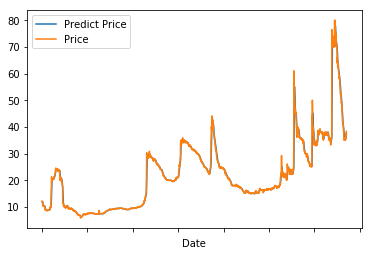

In [31]:
roll_mean_model.plot()

In [30]:
p = figure(plot_width=800, plot_height = 500,
           x_axis_type='datetime')

p.line(roll_mean_model.index, roll_mean_model["Price"],
       legend="Expected")
p.line(roll_mean_model.index, roll_mean_model["Predict Price"],
       color='orange', legend="Predicted")

p.xaxis.axis_label = 'Date'
p.xaxis.axis_label_text_font_size = "25px"
p.yaxis.axis_label = 'Price ($)'
p.yaxis.axis_label_text_font_size = "25px"

p.legend.location = "top_left"

p.title.text = "Rolling Average Prediction"
p.title.text_font_size = "30px"
p.title.align = "center"

show(p)

Awesome, so now we have a baseline RMSE score to try to improve on.  At first glance an RMSE of ~$1.77 seems pretty alright as we are dealing in dollars.  I am cautious that this model is only predicting one day into the future where it is likely that the price won't shift too much in that time period.  We haven't broken magic yet but still have a good place to start and learn.

## Do Some Neural Networks (ooohh Ahhh)

In this project, I'd like to investigate a long short-term memory (LSTM) model that is useful for predicting values based on the sequence of past data.  At its core, an LSTM model is a neural network but with a twist.  From a high level view of traditional neural networks, we are constantly changing the weights of each node based on their error.  Sometimes, this amount of change becomes so small that the weights just stop updating and our model stops training.  To get around such a problem, LSTM models have additional parts at each node that tell it what information is critical to remember.  Again, I didn't want to get bogged down in the details, but I'd highly recommend this [video](https://www.youtube.com/watch?v=QciIcRxJvsM) and this [video] (https://www.youtube.com/watch?v=SKMpmAOUa2Q) if you would like to learn more. 

Before we can launch into the magic of machine learning, LSTM models generally work better if all the data is close in scale.  Moreover, the data needs to fit within the activation function we use in our neural network.  Since the LSTM model use a *tanh* function, we'll scale everything between -1 and 1.  Let's write a quick function that can intake our training and testing data and then return both scaled as well as the scaler so we can do the inverse scaling when needed.

In [19]:
def scale(temp_train: np.ndarray, temp_test: np.ndarray):
    '''
        Intakes training/testing data and then scales them using a MinMaxScaler.
        
        Inputs:
            train - Array of training data
            test - Array of testing data
        Returns:
            scaler - scaling method used
            train_scaled - scaled training data
            test_scaled - scaled testing data
    '''
    # fit scaler
    scaler = MinMaxScaler(feature_range=(-1, 1))
    scaler = scaler.fit(temp_train)
    # transform train
    temp_train = train.reshape(temp_train.shape[0], temp_train.shape[1])
    train_scaled = scaler.transform(temp_train)
    # transform test
    temp_test = temp_test.reshape(temp_test.shape[0], temp_test.shape[1])
    test_scaled = scaler.transform(temp_test)
    return scaler, train_scaled, test_scaled

In [20]:
scaler, train_scaled, test_scaled = scale(train, test)

Now that we have all our data (or ducks) in a row, let's get down to the LSTM model.  Looking forward, we may want to adjust our neural network architecture.  Instead of re-writing code every time, let's write a reusable function.  I will talk briefly here about different parts of the function and then add comments in the code for additional detail.

The first thing we need to do is get our data in the proper shape the LSTM model expects.  An LSTM model takes in:

* **Samples**: Observations.  In this case, the dollar value of the card on each date.
* **Time Steps**: The time steps at each given observation.
* **Features**: Other features we want to add.  This row will be empty since we are working with univariable data. 

So what we'll input this this specific case is something that looks like (# of observations, 1, 1).  Where the 1's are the number of time steps forward (1 day) and number of features (1 price data).  

This input will feed into the `batch_input_shape` parameter of the LSTM model which corresponds to how many observations are going into the model at each pass.

The next thing I'd like to point out is the `stateful` parameter.  As the model goes from batch to batch, it will clear the layer.  Since we want our model to remember the past sequences, well set this parameter to `True`.

Finally, when we use `model.fit`, the data is naturally shuffled in each epoch.  Again, because sequence matters in our predictions, we'll flip the shuffle to `False`.

My general rule of thumb is start as simple as you can and build from there.  Thus, we'll start by making a neural network composed of one LSTM layer and one output layer.  Later, we can come back and mess around with the architecture to see if we can improve the model at all.


In [21]:
def fit_lstm(train: np.ndarray, n_lag:int, n_batch: int, nb_epoch: int, n_neurons: int):
    """
        Fits and trains a single layer LSTM model to the training data
        
        Inputs:
            train - Training data to fit the model to
            n_lag - Number of days our data is lagging
            n_batch - Amount of training data passed into the model before updating
            nb_epoch - Number of times going completely through the dataset
            n_neurons - Number of neurons in each layer
        Returns:
            model - LSTM model with Sequential() attributes
                Documentation: https://keras.io/models/sequential/
    """
    # Split the data into features and target variable
    X, y = train[:, 0:n_lag], train[:,n_lag:] # X is our features, y is our target variable
    # [samples, timesteps, features]
    
    # Reshape our feature data so it's in the proper shape for the LSTM model 
    X = X.reshape(X.shape[0],1, X.shape[1])
    # Surpress deprecation warnings
    warnings.filterwarnings("ignore")
    
    # Create the network
    model = Sequential()
    # Add the LSTM model layer
    model.add(LSTM(n_neurons, batch_input_shape = (n_batch, X.shape[1],
                                                   X.shape[2]), stateful=True))
    
    # Add the output layer
    model.add(Dense(y.shape[1]))
    model.compile(loss='mean_squared_error', optimizer = 'adam')
    for i in range(nb_epoch):
        # Print out every 5 epochs so we known where the model is
        if (i+1)%5 == 0:
            print('Epoch No. '+str(i+1)+'/'+str(nb_epoch))
        model.fit(X,y, epochs = 1, batch_size=n_batch, verbose=0,
                  shuffle=False)
        
        # Want to make sure each state is reset at the end of a training 
        model.reset_states()
    return model

Alright now that we built this reusable function, let's fit our data.  As for the relevant parameters we'll use:

* n_lag: 1, because when we transformed our data into the supervised form, we only shifted by one day.
* n_batch: 1, because at this juncture we're only looking one day head. 
* nb_epoch: 50, start semi-small so it doesn't take too much time and then ramp this up later
* n_neurons: 4, again start small and adjust this as we go. 

As noted, we are starting small and simple that we can see where we are at.  In a later post, I am planning on coming back and diving deeper into tuning each parameter.  One of the more important ideas I have learned shifting from academia to industry that getting a working version quickly and then iterating can go a long way compared to spending long periods of time trying to generate a perfect product.

In [22]:
magic_model = fit_lstm(train_scaled, n_lag=1, n_batch=1,
                       nb_epoch=50, n_neurons=4)

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Use tf.cast instead.
Epoch No. 5/50
Epoch No. 10/50
Epoch No. 15/50
Epoch No. 20/50
Epoch No. 25/50
Epoch No. 30/50
Epoch No. 35/50
Epoch No. 40/50
Epoch No. 45/50
Epoch No. 50/50


Cool, now that our model is trained on our training data, we can now see how it does on our testing data.  Again, to keep our code modular and clean we'll write a reusable function that will make a prediction given training data and the batch size from that data we want to look at.  

Once we do our forecast, however, remember that we transformed our data to be first stationary by differencing it and then scaled it to work with our LSTM model.  Therefore, when we get outputs from our model, they will be values such as -.001 which are not actual useful values of money.  Thus, let's write some addition functions that will do the inverse differencing and inverse scaling so we can get actual monetary values from our predictions.

In [23]:
def forecast_lstm(model, batch_size: int, X: np.ndarray):
    """
        Reshapes input data and predicts based on the input trained model
        
        Inputs:
            model - trained LSTM model
            batch_size - int, number of values we want to use to predict forward
            X - array of floats, training data
        Returns:
            yhat - array of floats, predicted value
    """
    X = X.reshape(1, 1, len(X)) # Shape the data so it can be used in the LSTM
    yhat = model.predict(X, batch_size=batch_size)
    return yhat[0,0]

def invert_scale(scaler, X: np.ndarray, value: np.ndarray):
    """
        Does the inverse of whatever scaler is passed in

        Inputs:
            scaler - scaler oringally used
            X - array of floats, Orignal data to adjust
            value - array of floats, how to change the data
        Returns:
            inverted - array of floats, input value that has been inverted
    """
    new_row = [x for x in X] + [value]
    array = np.array(new_row)
    array = array.reshape(1, len(array))
    inverted = scaler.inverse_transform(array)
    return inverted[0, -1]

def inverse_difference(history, yhat: np.ndarray, interval: int=1):
    """
        Adds the prediction value to the orginal data values 

        Inputs:
            history - orginal data
            yhat - array of floats, difference to add
            interval - int, index of original data to add the number to
        Returns:
            Orginal data plus the difference.
    """
    return yhat + history[-interval]

Now we can put all these functions in a loop that will predict forward one value at a time.  We'll create a log that we can look at individual RMSE per day and print out a bit of that log to see where we’re at.

In [24]:
predictions = list()
prediction_log = list() # Log of predictions with expected values
prediction_stats = list() # Keep track of predicted, expected, and RMSE numbers
for i in range(len(test_scaled)):
    X, y = test_scaled[i, 0:-1], test_scaled[i,-1]
    yhat = forecast_lstm(magic_model, 1, X)
    yhat = invert_scale(scaler, X, yhat)
    yhat = inverse_difference(data.values, yhat, len(test_scaled)+1-i)
    
    predictions.append(yhat)
    expected = data.values[len(train)+ i + 1] #  Go from the end of the training values as the actual values
    
    RMSE = sqrt(mean_squared_error(expected, yhat))
    temp_stats = np.array([i+1, yhat, expected, RMSE])
    prediction_stats.append(temp_stats)
    prediction_log.append('Day=%d, Predicted=$%f, Expected=$%f, RMSE=$%f' % (i+1, yhat, expected, RMSE))
    
    
for i in range(10):
    print(prediction_log[i])

Day=1, Predicted=$31.749894, Expected=$31.410000, RMSE=$0.339894
Day=2, Predicted=$31.536945, Expected=$31.320000, RMSE=$0.216945
Day=3, Predicted=$31.354650, Expected=$31.200000, RMSE=$0.154650
Day=4, Predicted=$31.178868, Expected=$30.940000, RMSE=$0.238868
Day=5, Predicted=$30.866348, Expected=$31.100000, RMSE=$0.233652
Day=6, Predicted=$31.065070, Expected=$31.100000, RMSE=$0.034930
Day=7, Predicted=$31.068124, Expected=$31.050000, RMSE=$0.018124
Day=8, Predicted=$31.014242, Expected=$30.880000, RMSE=$0.134242
Day=9, Predicted=$30.823297, Expected=$30.900000, RMSE=$0.076703
Day=10, Predicted=$30.861038, Expected=$30.880000, RMSE=$0.018962


Notice that the model outputs Day=#" which is not a great and we would rather have it as an actual datetime.  We can use the split point from when we split our data into training and testing data to find the actual dates that correlate to those day numbers.

In [25]:
split_date = data.index[split_index]
predictions_df = pd.DataFrame(prediction_stats,
                              columns=['Date', 'Predicted', 'Expected', 'RMSE'])

# Switch the days to the date
predictions_df["Date"] = data.index[split_index:]

We can do a quick sanity check by looking at the last date with our original data and our prediction dataframe.  If they lined up that means we got the right corresponding dates.

In [26]:
print("Original Data:")
data.tail()

Original Data:


,Price
Date,
2020-01-30,37.66
2020-01-31,37.09
2020-02-01,36.99
2020-02-02,37.89
2020-02-03,38.28


In [27]:
print("Prediction Data:")
predictions_df.tail()

Prediction Data:


,Date,Predicted,Expected,RMSE
1672,2020-01-30,37.141915,37.66,0.518085
1673,2020-01-31,37.837232,37.09,0.747232
1674,2020-02-01,37.092295,36.99,0.102295
1675,2020-02-02,36.964143,37.89,0.925857
1676,2020-02-03,37.999545,38.28,0.280455


Awesome, we can see that the "price" column matches the "Expected" column for each data.  Let's plot these values again using Bokeh so the graph can be interactive. Remember we are only plotting the last 50% of the data that we held out for testing.

In [28]:
# Plot the predicted and expected prices
p = figure(plot_width=850, plot_height = 350,
           x_axis_type='datetime', title="Stoneforge Mystic Price")


p.line(predictions_df['Date'], predictions_df['Predicted'],
            legend='Predicted')
p.line(predictions_df['Date'], predictions_df['Expected'],
            color='orange', legend="Expected")

p.xaxis.axis_label = 'Date'
p.xaxis.axis_label_text_font_size = "25px"
p.yaxis.axis_label = 'Price ($)'
p.yaxis.axis_label_text_font_size = "25px"

p.title.text = "Expected vs Predicted"
p.title.text_font_size = "30px"
p.title.align = "center"

p.legend.location = "top_left"

show(p)

# Plot the RMSE vs time
p1 = figure(plot_width=850, plot_height = 350,
           x_axis_type='datetime', title="Stoneforge Mystic Price")


p1.line(predictions_df['Date'], predictions_df['RMSE'],
            legend='RMSE')

p1.xaxis.axis_label = 'Date'
p1.xaxis.axis_label_text_font_size = "25px"
p1.yaxis.axis_label = 'RMSE ($)'
p1.yaxis.axis_label_text_font_size = "25px"

p1.title.text = "RMSE"
p1.title.text_font_size = "30px"
p1.title.align = "center"

p1.legend.location = "top_right"

show(p1)

Interesting, our predictions seem to be right on top of our expected values and our RMSE seem low.  We do get, however, huge jumps in our RMSE that seem to occur when there are spikes in prices.  These spikes make sense as our model is only looking at day level prices and if the cards shift suddenly in one day or over a few days, it would be hard to capture that movement.  My initial guess is that these spikes come from either the card being banned or unbanned in certain formats (because the demand for them to go up or down) or people realize the card pairs well with a newly printed card and thus the demand goes up.  These are all factors I will look to answer later down the road when we get to multi-variable predictions but for our first past, this seems good enough.  

Finally, I rather suspected that we would get on average a low RMSE because we are only going one day ahead.  The more interesting task would be to predict a week or a month ahead in price.  Finally, while neural networks are quite the rage, we should be rigorous data scientists and test if our simple rolling average prediction performs the same.  Let's print out our RMSE from both models.

In [29]:
print("Rolling Mean RMSE: $" + str(round(roll_mean_model_RMSE,4)))
print("LSTM RMSE: $" + str(round(predictions_df["RMSE"].mean(),4)))

Rolling Mean RMSE: $1.7671
LSTM RMSE: $0.3452


## Conclusion 

It seems that our LSTM model was able to perform better than the rolling average week model by having a lower RMSE score.  So, we can say purely on that metric, the LSTM model is better in this case.  We would further need to test this LSTM against other cards to see how well the model generalizes.  The other factors to consider, however, is how scalable is the LSTM in terms of speed and cost.  If you noticed it took a bit to go through only 50 epochs but less than a second to calculate the rolling mean.  Picking one or the other will depend upon the end use case.  For example, a real time series prediction operating on data points coming in at a second or less might need a little faster to train metric such as a rolling mean.  As with anything it's always a tradeoff.  Is that extra error worth the speed in delivering value compared to a bulky LSTM model?  These are always the questions to ask when deciding.  

Stepping off my soapbox now and returning to the project.  In this project we web scraped time series price data on a magic card.  In [part 1](), we then used a combination of visualization and the Augmented Dicky-Fuller test to determined that our data was not stationary.  This led to us applying some transformation to the data so it can be used in models that assume stationary data.  In part 2, we used a rolling mean model as a baseline to compare to the long-short term memory model that we built.  As noted above, I don't think we broke the finance part of magic because we were only predicting a day ahead, but this was a great project to get our feet wet in learning about time-series models.

Going forward, I would like to try to predict a week ahead in price.  Additionally, I would like to add additional variables such as bannings or new set releases to this time series model.


As always, this is a learning experience, so I welcome questions, comments, and suggestions for improvements. Email me at davidesmoleydelgado@gmail.com or @davidesdelgado on twitter.